# Imports and Functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import xarray as xr
import dask as da
import xesmf as xe
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.models import load_model
from keras.utils import Sequence
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import random

import time

import pandas as pd

# For debugging
def print_ds(ds, n_samples=4):
    """
    Print random samples from an Xarray Dataset.
    
    Parameters:
    ds (xr.Dataset): The Xarray Dataset.
    n_samples (int): Number of random samples to print.
    """
    
    # Check if the dataset has the necessary dimensions
    if not all(dim in ds.dims for dim in ['time', 'lat', 'lon', 'lev']):
        raise ValueError("Dataset must have 'time', 'lat', and 'lon' dimensions.")
    
    # Randomly select indices for time, lat, and lon
    time_indices = [0] * n_samples
    lat_indices = [5] * n_samples
    lon_indices = [0] * n_samples
    lev_indices = [71, 70, 0, 36]

    # time_indices = ['2006-01-08T10:30:00.000000000'] * n_samples
    # lat_indices = [45] * n_samples
    # lon_indices = [-100] * n_samples
    # lev_indices = [71, 70, 0, 36]

    assert n_samples == len(lev_indices)

    levels = list(ds['lev'].values)
    
    # Extract and print the random observations
    for i in range(n_samples):
        t_idx = time_indices[i]
        lat_idx = lat_indices[i]
        lon_idx = lon_indices[i]
        lev_idx = lev_indices[i]
        print("Level:", levels[lev_idx])
        observation = ds.isel(time=t_idx, lat=lat_idx, lon=lon_idx, lev=lev_idx)
        # observation = ds.sel(time=[t_idx], lat=[lat_idx], lon=[lon_idx], lev=[lev_idx])
        print(f"Observation {i+1}:")
        print(f"Values: {observation.to_array().values}")
        print()

    

def build_wnet(hp):

    n_feat =  hp['num_features']
    input_dat = keras.Input(shape=(n_feat,))
    initializer = tf.keras.initializers.HeUniform()
  
    x =  input_dat
    for hidden_layer_size in hp['hidden_layer_sizes']:
        x = layers.Dense(hidden_layer_size, kernel_initializer=initializer)(x) 
        x = layers.LeakyReLU(alpha=0.2)(x)       
	
    output =  layers.Dense(1)(x)
    model = keras.Model(input_dat, output)
    opt = tf.keras.optimizers.Adam(learning_rate=hp['learning_rate'], amsgrad=True)
    model.compile(loss=polyMSE, optimizer=opt)

    return model 
    

def polyMSE(ytrue,ypred):      
    mse =  tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)      
    x = tf.where(ypred > 1e-6, ypred, 0)  
    y = tf.where(ytrue > 1e-6, ytrue, 0) 
    
    m1 =  0.
    m2 = 0.
    for  n in range(2, 16, 2): 
        k = tf.constant(n*0.1)
        m1 = tf.pow(x, k) + m1
        m2 = tf.pow(y, k) + m2
    
    return  tf.reduce_mean(mse(m1, m2))


def set_callbacks(name = "Ensemble_prior", patience=20 ):
    # SET CALLBACKS
    early_stop = EarlyStopping(monitor='val_loss', 
                       min_delta=0.000000001,  
                       patience=patience, 
                       verbose=1)  

    csv_logger = CSVLogger(name + '.csv', append=True)

    model_checkpoint = ModelCheckpoint(name + '.hdf5',
                               monitor='val_loss', 
                               verbose=1,
                               save_best_only=True, 
                               mode='min')
    callbacks = [csv_logger, model_checkpoint, early_stop]   
    return callbacks  
 

def standardize(ds, s, m):
    assert len(list(ds.data_vars)) == len(m)

    # data_vars are ['T', 'AIRD', 'U', 'V', 'W', 'KM', "RI', 'QV', 'QI', 'QL']
    for i, var in  enumerate(ds.data_vars):  
        ds[var] = (ds[var] - m[i])/s[i]

    return ds

class get_dataset():

    LEV1 = 1
    LEV2 = 72
    VARS_IN = ['T', 'AIRD', 'U', 'V', 'W', 'KM', 'RI', 'QV', 'QI', 'QL']
    MEANS = [243.9, 0.6, 6.3, 0.013, 0.0002, 5.04, 21.8, 0.002, 9.75e-7, 7.87e-6]
    STDS = [30.3, 0.42, 16.1, 7.9, 0.05, 20.6, 20.8, 0.0036, 7.09e-6, 2.7e-5]
    SURF_VARS = ['AIRD', 'KM', 'RI', 'QV']
    FEATS = len(VARS_IN) + len(SURF_VARS) # 14
    CHUNK = {"lat": -1, "lon": -1, "lev": -1, "time": 1} # used in reading in 
                                                         # the data
    US_LOCS = {"lat1": 25, 
               "lat2": 50,
               "lon1": -150,
               "lon2": -50}
    COORDS = {"US": US_LOCS}

    def __init__(self, file_path = '/home/shared/data2/RIPS_Wnet_data.nc', name = "", location = None):
        self.file_path = file_path
        self.name = name 
        self.location = location
        self.global_data = xr.open_mfdataset(file_path) #, parallel=True)
        self.global_data = self.global_data.where(self.global_data['lev'] != 0, drop=True)
        
        if location:
            self.global_data = self.global_data.sel(lat=slice(self.COORDS[location]["lat1"], self.COORDS[location]["lat2"]), 
                                                    lon=slice(self.COORDS[location]["lon1"], self.COORDS[location]["lon2"]))

        self.time_stamps = list(self.global_data['time'].values)
        self.data_in = None
        self.data_out = None

    def get_data(self, times_per_batch):
        times = random.sample(self.time_stamps, times_per_batch)
        data_in = self.global_data[['T', 'AIRD', 'U', 'V', 'W', 'KM', 'RI', 'QV', 'QI', 'QL']]
        data_in = xr.map_blocks(standardize, data_in, kwargs={"m": self.MEANS, "s": self.STDS}, template=data_in)
        self.data_in = data_in
        self.data_out = self.global_data['Wstd']
    
    def get_Xy(self, batch_size = 2048):
        Xall = self.data_in
        yall = self.data_out
        levs = Xall.coords['lev'].values

        for var in self.SURF_VARS:
            Xs = Xall[var].sel(lev=[71]) # 1 level above surface
            Xsfc = Xs
            for lev in range(len(levs) - 1):
                Xsfc = xr.concat([Xsfc, Xs], dim='lev')
            Xsfc = Xsfc.assign_coords(lev=levs)
            Xall[f"{var}_sfc"] = Xsfc

        Xall = Xall.unify_chunks()
        Xall = Xall.to_array()
        Xall = Xall.stack(s=('time', 'lat', 'lon', 'lev'))
        Xall = Xall.rename({"variable": "ft"})
        Xall = Xall.squeeze()
        Xall = Xall.transpose()
        Xall = Xall.chunk({"ft": self.FEATS, "s": batch_size})

        yall = yall.stack(s=('time', 'lat', 'lon', 'lev'))
        yall = yall.squeeze()
        yall = yall.transpose()
        yall = yall.chunk({"s": batch_size})

        return Xall, yall

    def split_data(self, num_folds):
        # Split the data into k folds
        fold_size = len(self.time_stamps) // num_folds
        indices = list(range(len(self.time_stamps)))
        random.shuffle(indices)
        folds = [indices[i:i + fold_size] for i in range(0, len(indices), fold_size)]
        
        # Create a list of data subsets
        subsets = []
        for fold in folds:
            subset_data = self.global_data.isel(time=fold)
            subsets.append(subset_data)
        return subsets

    def get_fold_data(self, subsets, fold_index):
        # Get training and validation data for a specific fold
        train_subsets = [subsets[i] for i in range(len(subsets)) if i != fold_index]
        val_subset = subsets[fold_index]
        
        # Combine training subsets
        train_data = xr.concat(train_subsets, dim='time')
        
        # Create a temporary dataset object for training and validation data
        train_dataset = get_dataset(file_path=self.file_path, name=self.name, location=self.location)
        train_dataset.global_data = train_data
        val_dataset = get_dataset(file_path=self.file_path, name=self.name, location=self.location)
        val_dataset.global_data = val_subset
        
        return train_dataset, val_dataset



class DaskGenerator(Sequence):

    def __init__(self, dataset, epochs_per_batch, times_per_batch, batch_size = 2048):

        self.dataset = dataset
        self.name = self.dataset.name
        self.epochs_per_batch = epochs_per_batch
        self.times_per_batch = times_per_batch
        self.batch_size = batch_size

        # Load first round of data
        self.dataset.get_data(self.times_per_batch)
        X_train, y_train = self.dataset.get_Xy(self.batch_size)

        X_train = X_train.persist()
        y_train = y_train.persist()


        self.num_samples = len(y_train['s'].values)
        
        self.sample_batches = X_train.data.to_delayed()
        self.class_batches = y_train.data.to_delayed()

        self.count_epochs = 1
        self.old_t = time.time()

        # Ensure the sample and class batches have the same length
        assert len(self.sample_batches) == len(self.class_batches), 'lengths of samples and classes do not match'
        
        # Ensure each chunk contains all columns
        assert self.sample_batches.shape[1] == 1, 'all columns should be in each chunk'

    
    def __len__(self):
        '''Total number of batches, equivalent to Dask chunks in 0th dimension'''
        return len(self.sample_batches)


    def __getitem__(self, idx):
        '''Extract and compute a single chunk returned as (X, y). This is also a minibatch'''
        # Compute the data for the given index
        X, y = da.compute(self.sample_batches[idx, 0], self.class_batches[idx])
        # Convert the data to NumPy arrays and remove extra dimensions
        X = np.asarray(X).squeeze()
        y = np.asarray(y).squeeze()
        return X, y

    
    def on_epoch_end(self):
        self.t = time.time()
        self.count_epochs += 1  # Increment the epoch counter
        
        print("Epoch took :", self.t - self.old_t, "seconds")
        print("Epoch count: ", self.count_epochs)
        self.old_t = time.time()




# Training through K folds

In [2]:
# Set up GPUs and strategy
physical_devices = tf.config.list_physical_devices('GPU')
print("====Num GPUs:", len(physical_devices))
strategy = tf.distribute.MirroredStrategy()

====Num GPUs: 0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2024-08-08 16:48:00.205803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-08 16:48:00.353693: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Define hyperparameters
hp = {
    'Nlayers': 5,
    'Nnodes': 128,
    'learning_rate': 0.0001,
    'num_features': [],
    'hidden_layer_sizes': [],
}
hp['hidden_layer_sizes'] = (hp['Nnodes'],)*hp['Nlayers']
hp['num_features'] = 14


In [5]:
# Define training parameters
batch_size = 2048
epochs_per_batch = 1
epochs_per_batch_val = 1
times_per_batch = 1
times_per_batch_val = 1
nepochs = 1  # Number of epochs per fold
num_folds = 5  # Number of folds

In [5]:
dataset = get_dataset(file_path='/home/shared/data2/RIPS_Wnet_data.nc', name="dataset", location="US")
subsets = dataset.split_data(num_folds)

In [7]:
for fold_index in range(num_folds):
    print(f"Training fold {fold_index + 1} of {num_folds}")
    
    # Get train and validation datasets for this fold
    train_dataset, val_dataset = dataset.get_fold_data(subsets, fold_index)
    
    # Prepare data generators
    train_gen = DaskGenerator(train_dataset, epochs_per_batch, times_per_batch, batch_size)
    val_gen = DaskGenerator(val_dataset, epochs_per_batch_val, times_per_batch_val, batch_size)

    # Build and compile the model
    with strategy.scope():
        model = build_wnet(hp)
    
    steps = int(0.99 * train_gen.num_samples / batch_size)
    model_name = f"Ensemble_Prior_{fold_index + 1}"
    
    # Train the model
    history = model.fit(train_gen,
                        validation_data=val_gen,
                        steps_per_epoch=steps,
                        epochs=nepochs,
                        verbose=2,
                        callbacks=set_callbacks(model_name))

    # Save the trained model
    model_save_path = f"{model_name}.h5"
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

Training fold 1 of 5


/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-08-04 05:44:11.875186: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      sh

Epoch took : 24.976014137268066 seconds
Epoch count:  2

Epoch 1: val_loss improved from inf to 1.09350, saving model to Ensemble_Prior_1.hdf5
2854/2854 - 24s - loss: 1.1738 - val_loss: 1.0935 - 24s/epoch - 8ms/step
Epoch took : 37.28642988204956 seconds
Epoch count:  2
Model saved to Ensemble_Prior_1.h5
Training fold 2 of 5


/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-08-04 05:45:12.073184: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/

Epoch took : 23.012741565704346 seconds
Epoch count:  2

Epoch 1: val_loss improved from inf to 0.96645, saving model to Ensemble_Prior_2.hdf5
2854/2854 - 23s - loss: 1.2239 - val_loss: 0.9664 - 23s/epoch - 8ms/step
Epoch took : 34.53903532028198 seconds
Epoch count:  2
Model saved to Ensemble_Prior_2.h5
Training fold 3 of 5


/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-08-04 05:46:11.315557: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/

Epoch took : 23.538025617599487 seconds
Epoch count:  2

Epoch 1: val_loss improved from inf to 1.48890, saving model to Ensemble_Prior_3.hdf5
2854/2854 - 23s - loss: 1.0836 - val_loss: 1.4889 - 23s/epoch - 8ms/step
Epoch took : 35.52332258224487 seconds
Epoch count:  2
Model saved to Ensemble_Prior_3.h5
Training fold 4 of 5


/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-08-04 05:47:11.033823: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/

Epoch took : 22.99652075767517 seconds
Epoch count:  2

Epoch 1: val_loss improved from inf to 1.11371, saving model to Ensemble_Prior_4.hdf5
2854/2854 - 23s - loss: 1.2079 - val_loss: 1.1137 - 23s/epoch - 8ms/step
Epoch took : 34.99092984199524 seconds
Epoch count:  2
Model saved to Ensemble_Prior_4.h5
Training fold 5 of 5


/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-08-04 05:48:09.881855: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/

Epoch took : 22.904444932937622 seconds
Epoch count:  2

Epoch 1: val_loss improved from inf to 1.14150, saving model to Ensemble_Prior_5.hdf5
2854/2854 - 23s - loss: 1.1669 - val_loss: 1.1415 - 23s/epoch - 8ms/step
Epoch took : 34.41123557090759 seconds
Epoch count:  2
Model saved to Ensemble_Prior_5.h5


/home/varunjhaveri/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Preprocessing data and loading trained models

In [4]:
# loss function
import tensorflow as tf
from keras.utils import custom_object_scope

def polyMSE(ytrue,ypred):      
    mse =  tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)      

    ######### QUESTION #########################################################
    ############################################################################

    # not penalizing for negative values?
    x = tf.where(ypred > 1e-6, ypred, 0)  #use obs mask
    y = tf.where(ytrue > 1e-6, ytrue, 0) 
    
    m1 =  0.
    m2 = 0.
    for  n in range(2, 16, 2): # 2, 4, ..., 14
        k = tf.constant(n*0.1)
        m1 = tf.pow(x, k) + m1
        m2 = tf.pow(y, k) + m2

    return  tf.reduce_mean(mse(m1, m2))


# Load the models with custom objects
models = []
for i in range(5):
    model_path = f"Ensemble_Prior_{i+1}.h5"
    with custom_object_scope({'polyMSE': polyMSE}):
        model = tf.keras.models.load_model(model_path,compile=False)
        models.append(model)

2024-08-21 17:26:21.377249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-21 17:26:21.408298: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
num_folds=5
path = '/home/shared/data/nature_test_data.nc'
dataset = get_dataset(file_path=path, name="dataset", location="US")
splitting = dataset.split_data(num_folds)

In [6]:
# Combine data again after splitting
def combine_subsets(subsets):
    # Combine the subsets into a single dataset
    combined_data = xr.concat(subsets, dim='time')
    return combined_data

# Get the subsets from splitting
subset = splitting  # Assuming 'splitting' contains the subsets

# Combine all subsets back into a single dataset
combined_dataset = combine_subsets(subset)
combined_dataset_y = combine_subsets(subset)

In [7]:
filtered_dataset = combined_dataset.where(combined_dataset['lev'] != 0, drop=True)
filtered_dataset_input = filtered_dataset.drop_vars('Wstd')
filtered_with_wstd = combined_dataset.where(combined_dataset['lev'] != 0, drop=True)
combined_dataset = combined_dataset.where(combined_dataset['lev'] != 0, drop=True)

In [8]:
#global_dataset = xr.open_mfdataset(g5nr_path, parallel=True)
filtered_dataset_wstd = combined_dataset_y.where(combined_dataset_y['lev'] != 0, drop=True)
vars_to_drop = ["T", "AIRD", "U", "V", "W", "KM", "RI", "QV", "QI", "QL"]
wstd_global = filtered_dataset_wstd.drop_vars(vars_to_drop)
wstd_obs = wstd_global['Wstd'].values

# Functions for pre processing in order to make predictions

In [9]:
# Functions

def standardize(ds):
  i = 0
  m= [243.9, 0.6, 6.3, 0.013, 0.0002, 5.04, 21.8, 0.002, 9.75e-7, 7.87e-6]  #hardcoded from G5NR
  s = [30.3, 0.42, 16.1, 7.9, 0.05, 20.6, 20.8, 0.0036, 7.09e-6, 2.7e-5]
  for v in  ds.data_vars:
   ds[v] = (ds[v] - m[i])/s[i]
   i = i+1   
  return ds

def log10_scaler(ds):
   func  = lambda x: np.log10(x)  
   return xr.apply_ufunc(func, ds, dask='parallelized')
   
def outlier(x):
  return abs((x - x.mean(dim='time')) / x.std(dim='time'))

def KS_score(yp, yo):	
    yp =  yp.data.flatten()
    yo =  yo.data.flatten()
    k  = ks_2samp(yo, yp)
    print(k) 
    return k[0]

def get_data(site='', chunk_size=512*72):
    path_asr = f'/home/shared/data/Wstd_asr_resampled_stdev30min_72lv_{site}.nc'
    path_merra = f"/home/shared/data/Merra_input_asr_72lv_{site}.nc"

    data_obs = xr.open_mfdataset(path_asr, parallel=True)
    data_merra = xr.open_mfdataset(path_merra, parallel=True, chunks={"time": 2560})

    # ================= process obs ====================
    data_obs = data_obs.where((data_obs != -9999.) and (data_obs < 15.))
    # some conditionals for if site is manus, twp, mao, or ena (we don't have this data)
    data_std = (data_obs.where(data_obs > 0.001)).groupby('time.month').map(outlier) # abs(anomaly/std)
    data_obs = data_obs.where(data_std < 2.5) # no outliers beyond 2 st dev?
    data_obs = data_obs.dropna('time', how='all', thresh=2) # keep only timesteps w/ >= 2 non-nan
    data_obs = data_obs.fillna(0) # fill missing vals w/ 0 (WHY THIS CHOICE?)
    
    # ================= process merra ==================
    data_merra = data_merra.resample(time="5min").interpolate("linear") # turn 3-hr intervals into 5 min ones
    data_merra = data_merra[['T', 'AIRD', 'U', 'V', 'W', 'KM', 'RI', 'QV', 'QI', 'QL']] # all this does is reorder vars
    
    # ================= align merra w/ obs ===================
    data_merra, data_obs = xr.align(data_merra, data_obs, exclude = {'height', 'lev'}) # (inner join) time steps of merra, obs

    # ================= prep model input X (standardize, add 4 surface vars) =================
    X = xr.map_blocks(standardize, data_merra, template=data_merra) # standardize (7 features, 10 vars)
    
    levs = X.coords['lev'].values
    num_levs = len(levs) # should be 72
    surface_vars = ['AIRD', 'KM', 'RI', 'QV']
    for sv in surface_vars: # get entire surface_var column (all time) for lev=71, remove level dimension becomes row
        sv_row = X[sv].sel(lev=[71]).squeeze() # lev 71 is 1 level above surface (lev 72)
        
        X_sv = sv_row
        for i in range(num_levs - 1): # append sv_row below X_sv to get 72 rows of sv_row
            X_sv = xr.concat([X_sv, sv_row], dim='lev')

        X[sv + "_sfc"] = X_sv.assign_coords(lev=levs)
    
    # ==================== clean up input X ========================
    X = X.unify_chunks() # chunk becomes (all timesteps, one level)
    
    X = X.to_array() # turn DataSet into DataArray
    # for above, data variables stacked (become 1st axis of new array), variables become coords
    
    X = X.rename({'variable':'feature'}) # optional, just using feature instead of variable
    X = X.stack(s=('time', 'lev')) # time and lev coords stacked into single coord
    X = X.squeeze() # removes length-1 axes (none in this case)
    X = X.transpose()
    X = X.chunk({'s': 72*1024}) # not sure about this chunk choice - could be hardware specific?
    
    # ==================== clean up target Y =======================
    y = data_obs['W_asr_std'] # get DataArray from DataSet
    y = y.stack(s=('time', 'height')) # all 72 levels for one time, and then next time
    y = y.chunk({'s': 72*1024})

    # manually triggers loading from disk/remote source to memory
    # might be necessary when working w/ many files on disk?
    return X.load(), y.load() 

    
#### FUNCTIONS ####

# globally define loss function
mse =  tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

def standardize(ds, s=1, m=0):
  i = 0
  #['T', 'AIRD', 'U', 'V', 'W', 'KM', 'RI', 'QV', 'QI', 'QL'] 
  for v in  ds.data_vars:  
   ds[v] = (ds[v] - m[i])/s[i]
   i = i+1
  return ds
 
     
def get_random_files(pth, nts):
    return None
  # lall = glob.glob(pth) 
  # f_ind = np.random.randint(0, len(lall)-1, nts)
  # fils = [lall[i] for i in f_ind] 
  # return fils

def switch_var(V, fils):
  #switch strings in two steps
  old = '0.0625_deg/inst/inst30mn_3d_W_Nv'
  new = '0.5000_deg/tavg/tavg01hr_3d_' + V + '_Cv'
  flsv = [sub.replace(old, new) for sub in fils]
  old  = 'inst30mn_3d_W_Nv'
  new =  'tavg01hr_3d_' + V + '_Cv'
  flsv = [sub.replace(old, new) for sub in flsv]  
  return [flsv]

def dens (ds): 
    d = ds.PL/287.0/ds.T
    ds.PL.data = d
    return ds

def QCT (ds): 
    d = ds.QL + ds.QI    
    ds.QL.data = d
    return ds
           
def set_callbacks(nam = "WNet" ):
    # SET CALLBACKS
    early_stop = EarlyStopping(monitor='val_loss', 
                       min_delta=0.000000001,  
                       patience=20, 
                       verbose=1)  

    csv_logger = CSVLogger(nam + '.csv', append=True)

    model_checkpoint = ModelCheckpoint(nam + '.hdf5',
                               monitor='val_loss', 
                               verbose=1,
                               save_best_only=True, 
                               mode='min')
    cllbcks = [csv_logger, model_checkpoint, early_stop]   
    return cllbcks  



def build_wnet(hp):

    n_feat =  hp['n_features']
    input_dat = keras.Input(shape=(n_feat,))
    initializer = tf.keras.initializers.HeUniform()
  
    x =  input_dat
    for hidden_layer_size in hp['hidden_layer_sizes']:
        x = layers.Dense(hidden_layer_size, kernel_initializer=initializer)(x) 
        x = layers.LeakyReLU(alpha=0.2)(x)       
	
    output =  layers.Dense(1)(x)
    model = keras.Model(input_dat, output)
    opt = tf.keras.optimizers.Adam(learning_rate=hp['lr'], amsgrad=True)
    model.compile(loss=polyMSE, optimizer=opt)

    return model  

def polyMSE(ytrue, ypred):
    st=2
    mx=10
    # Normalize predictions and true values
    ytrue = tf.math.l2_normalize(ytrue, axis=-1)
    ypred = tf.math.l2_normalize(ypred, axis=-1)

    # Initialize MSE loss
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    # Mask small values
    x = tf.where(ypred > 1e-6, ypred, 0)
    y = tf.where(ytrue > 1e-6, ytrue, 0)

    # Polynomial aggregation
    aux = 0.
    m1 = 0.
    m2 = 0.
    for n in range(0, mx, st):
        k = tf.constant((n + st) * 0.1)
        m1 += tf.pow(x, k)
        m2 += tf.pow(y, k)

    # Weighted aggregation of polynomial terms
    weights = tf.linspace(1.0, 2.0, num=mx // st)
    weighted_m1 = m1 * tf.reshape(weights, (1, -1))
    weighted_m2 = m2 * tf.reshape(weights, (1, -1))

    # Compute MSE loss
    mse_loss = mse(tf.reduce_sum(weighted_m1, axis=-1), tf.reduce_sum(weighted_m2, axis=-1))
    
    # Compute and return mean loss
    return tf.reduce_mean(mse_loss)

    
def polyMSE(ytrue,ypred):            
    st =  2
    mx =  14
    x = tf.where(ypred > 1e-6, ypred, 0)  #use obs mask
    y = tf.where(ytrue > 1e-6, ytrue, 0) 

    aux = 0.
    m1 =  0.
    m2 = 0.
    for  n in range(0, mx, st):
        k = tf.constant((n+st)*0.1)
        m1 =tf.pow(x, k) + m1
        m2 = tf.pow(y, k) + m2

    return  tf.reduce_mean(mse(m1, m2)) 


class get_dts():
   def __init__(self, ndts =  1, nam ="def",  exp_out=1, batch_size = 32000, subsample=5):  #creates a class that will handle ndsts files
    yr =  "Y2006/" 
    mo = "M*/"
    dy =  "D*/*30z*"

    self.batch_size = batch_size
    self.lev1 = 1
    self.lev2 = 72
    self.vars_in = ['T', 'PL', 'U', 'V', 'W', 'KM', 'RI', 'QV', 'QI', 'QL'] 
    self.n_features_in_ = len(self.vars_in)*72 #72 is hardcoded number of levels
    self.means= [243.9, 0.6, 6.3, 0.013, 0.0002, 5.04, 21.8, 0.002, 9.75e-7, 7.87e-6] #hardcoded from G5NR based on 100 time steps
    self.stds =[30.3, 0.42, 16.1, 7.9, 0.05, 20.6, 20.8, 0.0036, 7.09e-6, 2.7e-5]
    self.surf_vars =  ['AIRD', 'KM', 'RI', 'QV']
    self.feats = len(self.vars_in)+len(self.surf_vars) #14 is the number
    self.chk = { "lat": -1, "lon": -1, "lev":  -1, "time": 1} # needed so we can regrid
    self.in_dir  =  ""  # INPUT PATH
    self.out_dir  = ""  # path to output target data
    self.path_out =  self.out_dir +  yr + mo + dy
    self.create_regridder =  True       
    self.name = nam
    #get nts files 
    self.fls = get_random_files(self.path_out,ndts)
   
   def get_fls_batch (self, dt_batch_size):
     for i in range(0, len(self.fls), dt_batch_size):
       yield self.fls[i:i + dt_batch_size]
       if i >= len(self.fls):
           i = 0
             
   def  get_data(self, this_fls, manual_data=None):
     
      # self.dat_out =  xr.open_mfdataset(this_fls, chunks=self.chk, parallel=True)

      # WE DID THIS ALREADY
      # self.dat_out =  self.dat_out.coarsen(lat=8, lon=8, boundary="trim").std() #coarsen to about half degree using standard deviation as lumping function      
      self.levs =  72 # manual number
      vars_in  = self.vars_in
      self.n_features_in_ = len(vars_in)*self.levs
      self.feats = len(vars_in)  
       
      ###Calculate density 
      manual_data = manual_data.unify_chunks()           
      self.dat_in= xr.map_blocks(standardize, manual_data, kwargs={"m":self.means, "s": self.stds}, template=manual_data)
      
   def get_Xy(self, make_y_array =  True,  batch_size  =5120, test = False, x_reshape =False, manual_data = None):
   
        self.batch_size = batch_size
        if test:
           self.get_data(self.fls, manual_data) 

        # self.regrid_out()

        Xall = self.dat_in
            
        levs = Xall.coords['lev'].values
        nlev =  len(levs)
	
	   #concatenate surface variables
        for v in self.surf_vars:        
            vv =     Xall[v]
            Xs =  vv.sel(lev=[71]) #level 1 above surface
            Xsfc =  Xs
            v2 =  v + "_sfc"
            for l in range(nlev-1):         
                Xsfc = xr.concat([Xsfc, Xs], dim ='lev')                 
            Xsfc =  Xsfc.assign_coords(lev=levs)
            Xall[v2] =  Xsfc
            
        Xall =  Xall.unify_chunks()
        Xall = Xall.to_array()
        Xall = Xall.stack( s = ('time', 'lat', 'lon', 'lev')) 
        Xall = Xall.rename({"variable":"ft"})                       
        Xall = Xall.squeeze()
        Xall = Xall.transpose()
        Xall = Xall.chunk({"ft":self.n_features_in_, "s": 102000}) #chunked this way aligns the blocks/chunks with the samples 
        
        Xall = Xall.chunk({"ft":self.n_features_in_, "s": batch_size})
        if x_reshape:
            Xall =  Xall.rename({"ft":"variable"})
            Xall = Xall.expand_dims("w")
            Xall = Xall.transpose('s', 'variable', 'w') 
        
        return Xall #, yall
    

# Predictions of ensemble on US data

In [10]:
predictions=[]
for i in range(len(models)):
    wnet_prior = models[i]
    test_data =  get_dts(nam = 'test_data', batch_size =  102000)
    test_x =  test_data.get_Xy( make_y_array = False, batch_size = 512*72*2, test = True, x_reshape =  False, manual_data= filtered_dataset_input)
    X =  test_x.load()
    pred = wnet_prior.predict(X, batch_size=32768)
    y_pred = pred.reshape(5,51,201,72)
    predictions.append(y_pred)

113/113 [==============================] - 3s 24ms/step


In [11]:
y_obs = wstd_obs.reshape(5,51,201,72)

In [12]:
def mse(p, q):
    p = np.asarray(p, dtype=np.float32)
    q = np.asarray(q, dtype=np.float32)
    
    # Compute Mean Squared Error
    mse_value = np.mean((p - q) ** 2)
    
    return mse_value

def normalize(array):
    total = np.sum(array)
    return array / total if total != 0 else np.full(array.shape, 1.0 / len(array))

In [13]:
# Initialize lists to store MSE values for each model
mse_values_prior = [[] for _ in range(5)]  # One list for each model

# Calculate MSE values for each level and append them to the respective model's list
for i in range(72):
    y_obs_level = y_obs[:,:,:,i].flatten()

    for model_index in range(5):
        y_pred_level = predictions[model_index][:,:,:,i].flatten()
        
        p_prior = normalize(y_obs_level)
        q_prior = normalize(y_pred_level)
        
        mse_val_prior = mse(p_prior, q_prior)
        mse_values_prior[model_index].append(mse_val_prior)

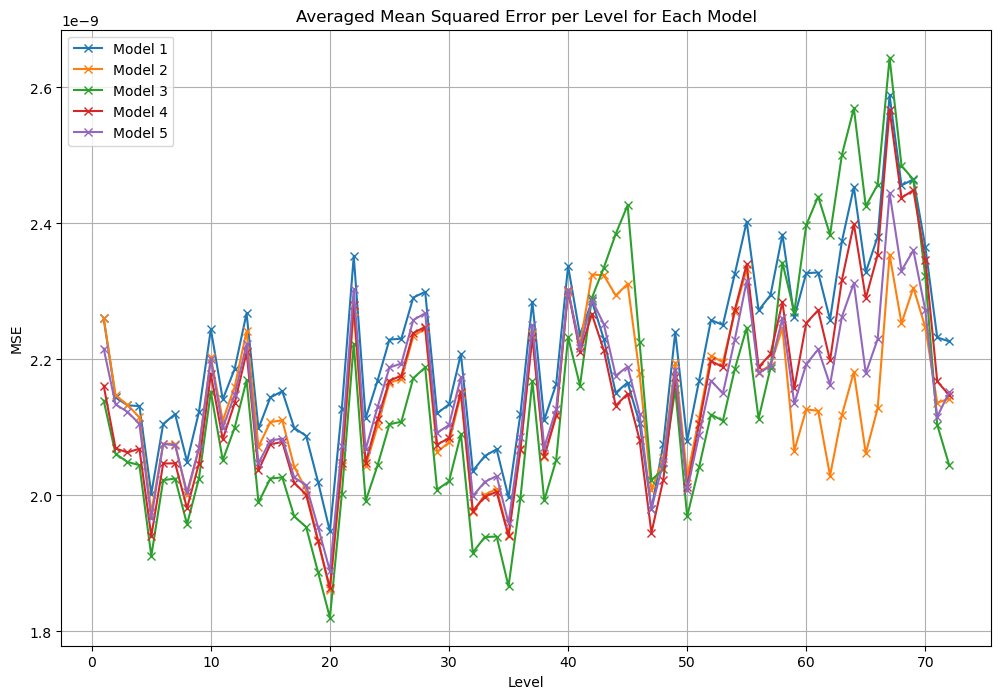

In [14]:
mse_df_prior = pd.DataFrame({
    'Level': range(1, 73),
    'Model 1': mse_values_prior[0],
    'Model 2': mse_values_prior[1],
    'Model 3': mse_values_prior[2],
    'Model 4': mse_values_prior[3],
    'Model 5': mse_values_prior[4],
})

plt.figure(figsize=(12, 8))

# Plot MSE for each model
for model_index in range(5):
    plt.plot(mse_df_prior['Level'], mse_df_prior[f'Model {model_index + 1}'], marker='x', label=f'Model {model_index + 1}')

plt.title('Averaged Mean Squared Error per Level for Each Model')
plt.xlabel('Level')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

#plt.savefig('mse_all_ensemble_models.png')

# Show the plot
plt.show()

In [15]:
# Initialize a list to store the model numbers with the lowest error for each level
best_models = []

# Iterate through each level to find the model with the lowest MSE
for i in range(72):
    # Get the MSE values for the current level across all models
    mse_values_for_level = [mse_values_prior[model_index][i] for model_index in range(5)]
    
    # Find the index of the minimum MSE value
    best_model_index = np.argmin(mse_values_for_level)
    
    # Append the model number (0-based index) to the best_models list
    best_models.append(best_model_index)

# Create a DataFrame to store the results
best_models_df = pd.DataFrame({
    'Level': range(1, 73),
    'Best Model': best_models
})

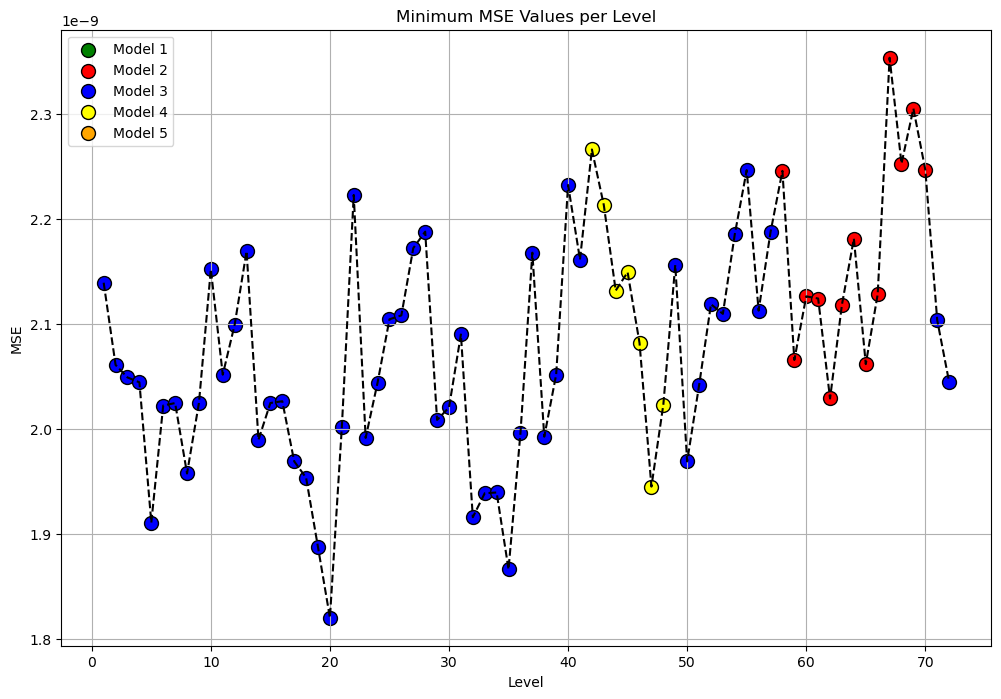

In [16]:
colors = ['green', 'red', 'blue', 'yellow', 'orange']

# Extract x and y values for the best models
x_values = best_models_df['Level']
y_values = [mse_values_prior[best_models[i]][i] for i in range(72)]

# Initialize the plot
plt.figure(figsize=(12, 8))

# Plot the MSE values with different colors for each model
for model_index in range(5):
    # Get indices where the best model is this one
    model_indices = [i for i in range(72) if best_models[i] == model_index]
    plt.scatter(np.array(model_indices) + 1, np.array([y_values[i] for i in model_indices]),
                color=colors[model_index], label=f'Model {model_index + 1}', s=100, edgecolor='black')
plt.plot(x_values, y_values, color='black', linestyle='--')
plt.title('Minimum MSE Values per Level')
plt.xlabel('Level')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
#plt.savefig('mse_best_ensemble_models.png')
plt.show()

In [17]:
# Count the number of levels assigned to each model
model_counts = best_models_df['Best Model'].value_counts().sort_index()

# Create a DataFrame to present the count of levels for each model
model_counts_df = pd.DataFrame({
    'Model Number': model_counts.index,
    'Number of Levels': model_counts.values
})

# Calculate the weights based on the number of levels assigned
total_levels = 72
model_counts_df['Weight'] = model_counts_df['Number of Levels'] / total_levels

# Display the weights with model numbers
print("Weights for each model based on the number of levels assigned:")
#model_counts_df.to_csv('ensemble_model_weights.csv', index=False)
model_counts_df

Weights for each model based on the number of levels assigned:


,Model Number,Number of Levels,Weight
0,1,13,0.180556
1,2,52,0.722222
2,3,7,0.097222


In [18]:
# Extract weights into a Series
weights = model_counts_df.set_index('Model Number')['Weight']

# Verify the weights and indices
print("Weights:\n", weights)
print("Indices in weights:\n", weights.index)


Weights:
 Model Number
1    0.180556
2    0.722222
3    0.097222
Name: Weight, dtype: float64
Indices in weights:
 Int64Index([1, 2, 3], dtype='int64', name='Model Number')


In [19]:
saved_weights=[0,0.180556,0.722222,0.097222,0]

In [20]:
# Initialize an array to store the weighted predictions
weighted = np.zeros(predictions[0].shape)

# Calculate the weighted average predictions

for model_index in range(5):
    weight = weights.get(model_index, 0)  # Use .get to avoid KeyError
    weighted += weight * predictions[model_index]

In [21]:
mse_values_ensemble = []

for i in range(72):
    y_pred_weighted = weighted[:,:,:,i].flatten()
    y_obs_level = y_obs[:,:,:,i].flatten()
    
    p_prior = normalize(y_obs_level)
    q_prior = normalize(y_pred_weighted)
    
    mse_val_ensemble = mse(p_prior, q_prior)
    mse_values_ensemble.append(mse_val_ensemble)

mse_df_ensemble = pd.DataFrame({'Level': range(1, 73), 'MSE for Wnet Prior Ensemble': mse_values_ensemble})

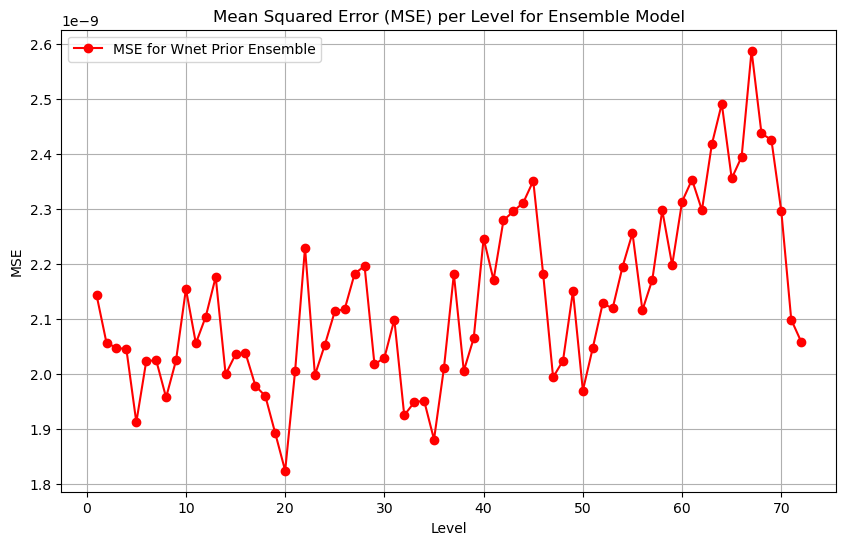

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(mse_df_ensemble['Level'], mse_df_ensemble['MSE for Wnet Prior Ensemble'], marker='o', color='r', label='MSE for Wnet Prior Ensemble')
plt.title('Mean Squared Error (MSE) per Level for Ensemble Model')
plt.xlabel('Level')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
#plt.savefig('mse_ensemble_model.png')
plt.show()

# Predictions for original Wnet_prior on US data

In [23]:
modelpath_wnet_prior = "/home/shared/models/Wnet_prior.h5"
wnet_prior = load_model(modelpath_wnet_prior, compile=False)
test_data =  get_dts(nam = 'test_data', batch_size =  102000)
test_x =  test_data.get_Xy( make_y_array = False, batch_size = 512*72*2, test = True, x_reshape =  False, manual_data= filtered_dataset_input)
X =  test_x.load()
y_hat_wnet_prior = wnet_prior.predict(X, batch_size=32768)

113/113 [==============================] - 3s 24ms/step


In [24]:
y_obs_prior = wstd_obs.reshape(5,51,201,72)
y_pred_prior = y_hat_wnet_prior.reshape(5,51,201,72)

In [25]:
mse_values_og = []

for i in range(72):
    y_pred_level = y_pred_prior[:,:,:,i].flatten()
    y_obs_level = y_obs_prior[:,:,:,i].flatten()
    
    p = normalize(y_obs_level)
    q = normalize(y_pred_level)
    
    mse_val = mse(p, q)
    mse_values_og.append(mse_val)

mse_df_og = pd.DataFrame({'Level': range(1, 73), 'MSE for Wnet Prior Original': mse_values_og})
#mse_df_og.to_csv('wnet_prior_results.csv', index=False)

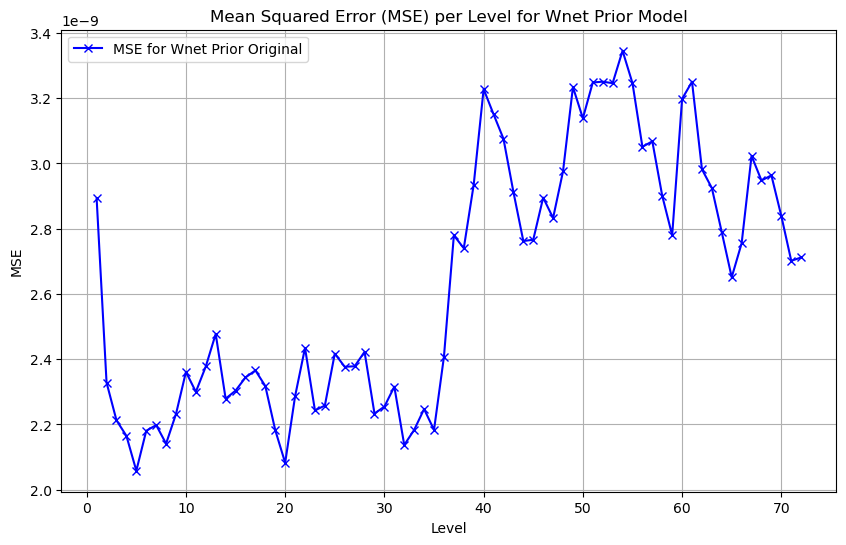

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(mse_df_og['Level'], mse_df_og['MSE for Wnet Prior Original'], marker='x', color='b', label='MSE for Wnet Prior Original')
plt.title('Mean Squared Error (MSE) per Level for Wnet Prior Model')
plt.xlabel('Level')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
#plt.savefig('mse_wnet_prior_model.png')
plt.show()

# Comparison of Original Wnet Prior and Ensemble Wnet Prior on US data

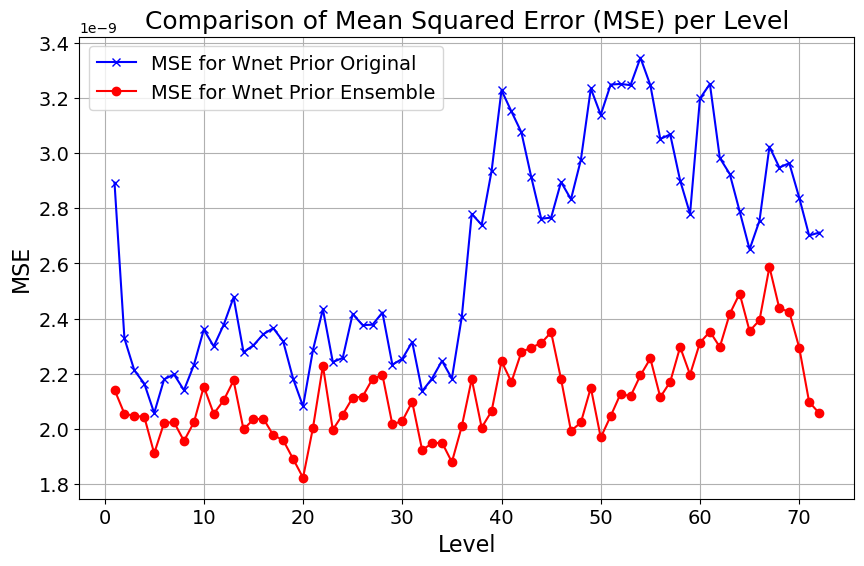

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(mse_df_og['Level'], mse_df_og['MSE for Wnet Prior Original'], marker='x', color='b', label='MSE for Wnet Prior Original')
plt.plot(mse_df_ensemble['Level'], mse_df_ensemble['MSE for Wnet Prior Ensemble'], marker='o', color='r', label='MSE for Wnet Prior Ensemble')
plt.title('Comparison of Mean Squared Error (MSE) per Level', fontsize=18)
plt.xlabel('Level', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)

#plt.savefig('mse_comparison.png')
plt.show()


In [28]:
# Merge DataFrames on the 'Level' column
merged_df = pd.merge(mse_df_og, mse_df_ensemble, on='Level')

# Calculate the difference between the original MSE and ensemble MSE
merged_df['MSE Ratio'] = ((merged_df['MSE for Wnet Prior Ensemble'])/(merged_df['MSE for Wnet Prior Original']))
#merged_df.to_csv('mse_comparison.csv', index=False)

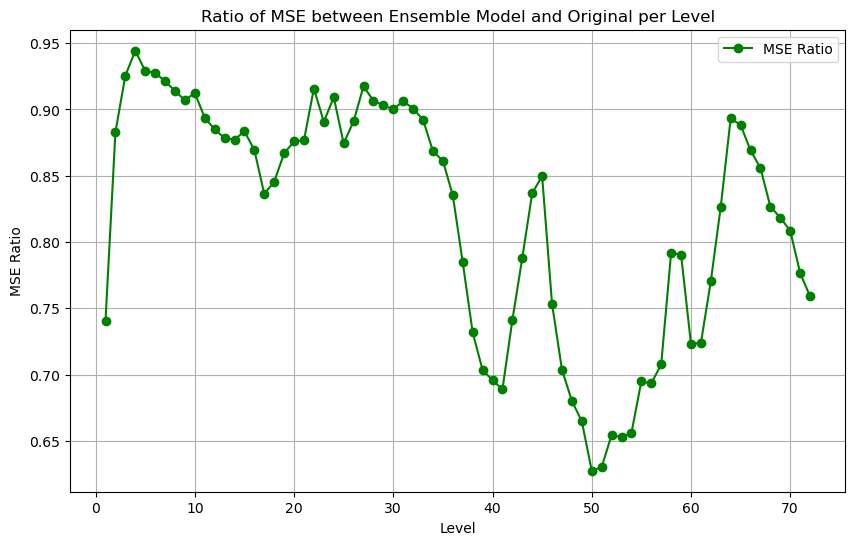

In [29]:
# Plot the MSE Difference
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Level'], merged_df['MSE Ratio'], marker='o', color='green', linestyle='-', label='MSE Ratio')
plt.title('Ratio of MSE between Ensemble Model and Original per Level')
plt.xlabel('Level')
plt.ylabel('MSE Ratio')
plt.legend()
plt.grid(True)
#plt.savefig('mse_comparison_ratio.png')
plt.show()

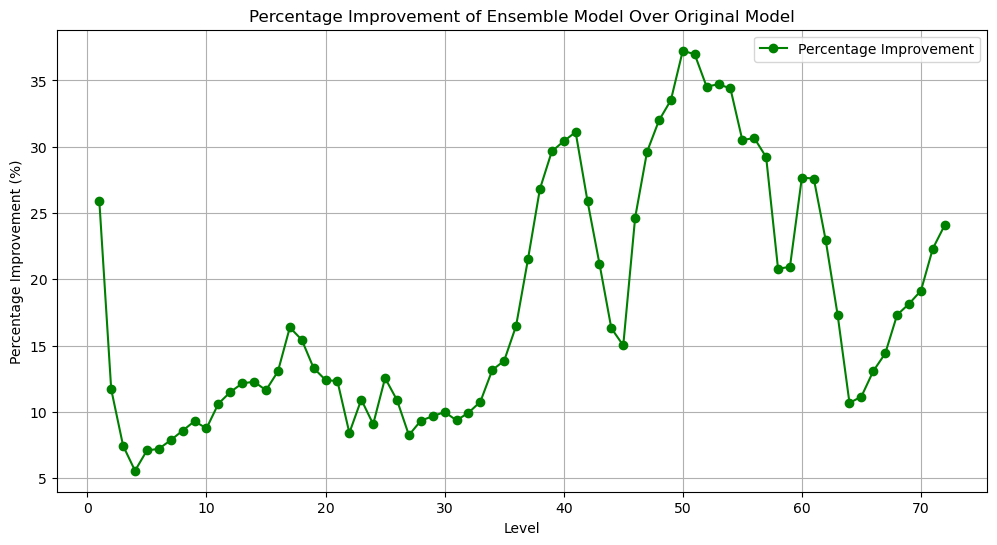

In [30]:
# Calculate percentage improvement
# Percentage improvement = (1 - Ratio) * 100
merged_df['Percentage Improvement'] = (1 - merged_df['MSE Ratio']) * 100
# Plot the percentage improvement
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Level'], merged_df['Percentage Improvement'], marker='o', color='green', label='Percentage Improvement')
plt.title('Percentage Improvement of Ensemble Model Over Original Model')
plt.xlabel('Level')
plt.ylabel('Percentage Improvement (%)')
plt.legend()
plt.grid(True)
#plt.savefig('mse_percentage_improvement.png')
plt.show() 

In [31]:
# Improvement statistics
average_improvement = merged_df['Percentage Improvement'].mean()
median_improvement = merged_df['Percentage Improvement'].median()
std_dev_improvement = merged_df['Percentage Improvement'].std()
min_improvement = merged_df['Percentage Improvement'].min()
max_improvement = merged_df['Percentage Improvement'].max()
positive_improvements = (merged_df['Percentage Improvement'] > 0).sum()
percentage_positive = (positive_improvements / len(merged_df)) * 100

In [32]:
print(f'Average Percentage Improvement: {average_improvement:.2f}%')
print(f'Median Percentage Improvement: {median_improvement:.2f}%')
print(f'Standard Deviation of Percentage Improvement: {std_dev_improvement:.2f}%')
print(f'Minimum Percentage Improvement: {min_improvement:.2f}%')
print(f'Maximum Percentage Improvement: {max_improvement:.2f}%')
print(f'Percentage of Levels with Positive Improvement: {percentage_positive:.2f}%')

Average Percentage Improvement: 18.02%
Median Percentage Improvement: 14.72%
Standard Deviation of Percentage Improvement: 9.03%
Minimum Percentage Improvement: 5.57%
Maximum Percentage Improvement: 37.24%
Percentage of Levels with Positive Improvement: 100.00%


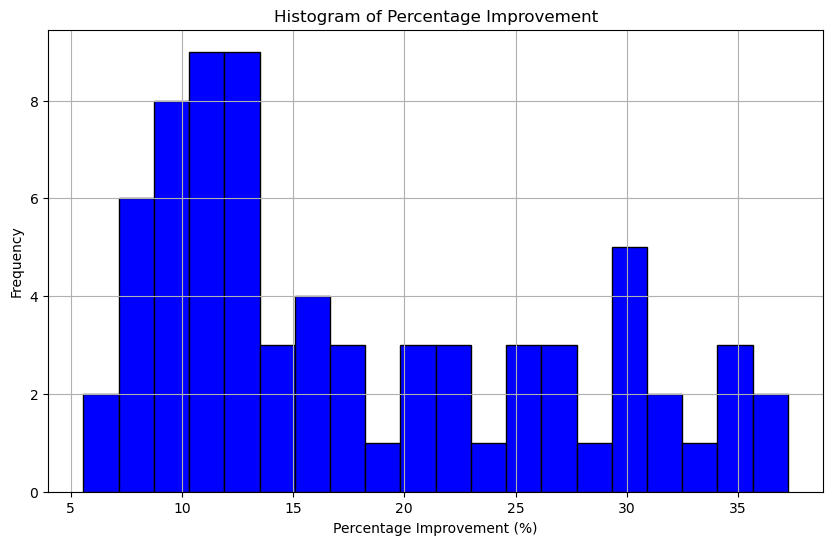

In [33]:
# Plot histogram of percentage improvement
plt.figure(figsize=(10, 6))
plt.hist(merged_df['Percentage Improvement'], bins=20, color='b', edgecolor='k')
plt.title('Histogram of Percentage Improvement')
plt.xlabel('Percentage Improvement (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

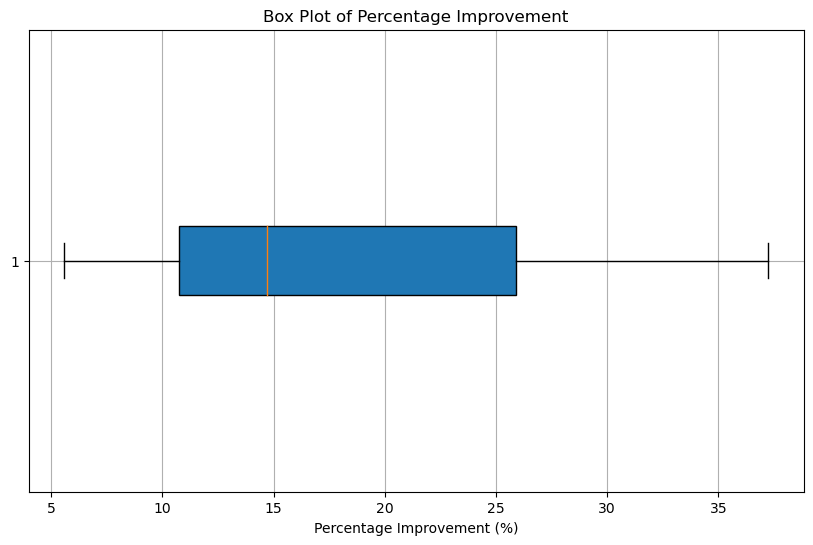

In [34]:

# Plot box plot of percentage improvement
plt.figure(figsize=(10, 6))
plt.boxplot(merged_df['Percentage Improvement'], vert=False, patch_artist=True)
plt.title('Box Plot of Percentage Improvement')
plt.xlabel('Percentage Improvement (%)')
plt.grid(True)
plt.show()

# Predictions on Merra data using Wnet

In [30]:
modelpath_wnet = "/home/shared/models/Wnet.h5"
wnet = load_model(modelpath_wnet, compile=False)

In [31]:
# reading in MERRA and ASR data the same way as PDF_bysite.py
def outlier(x):
    return abs((x-x.mean(dim='time')) / x.std(dim='time')) # causes some RuntimeWarnings (division by 0/nan)
def standardize(ds):
    i = 0
    # UNDERSTAND THESE LATER - m and s are mean/st dev for
    # ['T', 'AIRD', 'U', 'V', 'W', 'KM', 'RI', 'QV', 'QI', 'QL'] in that order??
    m = [243.9, 0.6, 6.3, 0.013, 0.0002, 5.04, 21.8, 0.002, 9.75e-7, 7.87e-6]  #hardcoded from G5NR
    s = [30.3, 0.42, 16.1, 7.9, 0.05, 20.6, 20.8, 0.0036, 7.09e-6, 2.7e-5]
    for v in  ds.data_vars:
        ds[v] = (ds[v] - m[i])/s[i]
        i = i+1
    return ds
    
# sites = asi, cor, nsa, sgp_cirrus, sgp_pbl
def get_data(site='', chunk_size=512*72):
    path_asr = f'/home/shared/data/Wstd_asr_resampled_stdev30min_72lv_{site}.nc'
    path_merra = f"/home/shared/data/Merra_input_asr_72lv_{site}.nc"

    data_obs = xr.open_mfdataset(path_asr, parallel=True)
    data_merra = xr.open_mfdataset(path_merra, parallel=True, chunks={"time": 2560})

    # ================= process obs ====================
    data_obs = data_obs.where((data_obs != -9999.) and (data_obs < 15.))
    # some conditionals for if site is manus, twp, mao, or ena (we don't have this data)
    data_std = (data_obs.where(data_obs > 0.001)).groupby('time.month').map(outlier) # abs(anomaly/std)
    data_obs = data_obs.where(data_std < 2.5) # no outliers beyond 2 st dev?
    data_obs = data_obs.dropna('time', how='all', thresh=2) # keep only timesteps w/ >= 2 non-nan
    data_obs = data_obs.fillna(0) # fill missing vals w/ 0 (WHY THIS CHOICE?)
    
    # ================= process merra ==================
    data_merra = data_merra.resample(time="5min").interpolate("linear") # turn 3-hr intervals into 5 min ones
    data_merra = data_merra[['T', 'AIRD', 'U', 'V', 'W', 'KM', 'RI', 'QV', 'QI', 'QL']] # all this does is reorder vars
    
    # ================= align merra w/ obs ===================
    data_merra, data_obs = xr.align(data_merra, data_obs, exclude = {'height', 'lev'}) # (inner join) time steps of merra, obs

    # ================= prep model input X (standardize, add 4 surface vars) =================
    X = xr.map_blocks(standardize, data_merra, template=data_merra) # standardize (7 features, 10 vars)
    
    levs = X.coords['lev'].values
    num_levs = len(levs) # should be 72
    surface_vars = ['AIRD', 'KM', 'RI', 'QV']
    for sv in surface_vars: # get entire surface_var column (all time) for lev=71, remove level dimension becomes row
        sv_row = X[sv].sel(lev=[71]).squeeze() # lev 71 is 1 level above surface (lev 72)
        
        X_sv = sv_row
        for i in range(num_levs - 1): # append sv_row below X_sv to get 72 rows of sv_row
            X_sv = xr.concat([X_sv, sv_row], dim='lev')

        X[sv + "_sfc"] = X_sv.assign_coords(lev=levs)
    
    # ==================== clean up input X ========================
    X = X.unify_chunks() # chunk becomes (all timesteps, one level)
    
    X = X.to_array() # turn DataSet into DataArray
    # for above, data variables stacked (become 1st axis of new array), variables become coords
    
    X = X.rename({'variable':'feature'}) # optional, just using feature instead of variable
    X = X.stack(s=('time', 'lev')) # time and lev coords stacked into single coord
    X = X.squeeze() # removes length-1 axes (none in this case)
    X = X.transpose()
    X = X.chunk({'s': 72*1024}) # not sure about this chunk choice - could be hardware specific?
    
    # ==================== clean up target Y =======================
    y = data_obs['W_asr_std'] # get DataArray from DataSet
    y = y.stack(s=('time', 'height')) # all 72 levels for one time, and then next time
    y = y.chunk({'s': 72*1024})

    # manually triggers loading from disk/remote source to memory
    # might be necessary when working w/ many files on disk?
    return X.load(), y.load() 
    

In [32]:
from sklearn.metrics import mean_squared_error
def compute_mse(predictions, observations):
    return mean_squared_error(observations, predictions)

In [33]:
sites = ["sgp_cirrus"] #sgp_pbl
level_of_interest = list(range(1, 73)) 

for site in sites:
    X, obs = get_data(site)
    wnet_preds = wnet.predict(X, batch_size=32768)
    time_coords = X.coords['time'].values
    lev_coords = X.coords['lev'].values
    wnet_predictions = wnet_preds.reshape(-1)
    mask = obs != 0
    obs_filtered = obs[mask]
    wnet_predictions_filtered = wnet_predictions[mask]
    lev_coords_filtered = lev_coords[mask]
    
    results = [] 
    
    valid_levels = [level for level in level_of_interest if (lev_coords_filtered == level).any()]
    
    
    for level in valid_levels:
        level_mask = lev_coords_filtered == level
        obs_level = obs_filtered[level_mask]
        wnet_pred_level = wnet_predictions_filtered[level_mask]
        
        if obs_level.size > 0 and wnet_pred_level.size > 0:
            mse_level = compute_mse(wnet_pred_level, obs_level)
            results.append({
                'Level': level,
                'MSE Wnet': mse_level
                
            })
    
    df_mse = pd.DataFrame(results)

25/25 [==============================] - 1s 24ms/step


In [34]:
df_mse

,Level,MSE Wnet
0,40,0.061459
1,41,0.063819
2,42,0.086959
3,43,0.026507
4,44,0.021603
5,45,0.016720
6,46,0.015194
7,47,0.018221
8,48,0.030279


# Predictions on Merra data using Ensemble Wnet prior

In [37]:
# loss function
import tensorflow as tf
from keras.utils import custom_object_scope

def polyMSE(ytrue,ypred):      
    mse =  tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)      

    ######### QUESTION #########################################################
    ############################################################################

    # not penalizing for negative values?
    x = tf.where(ypred > 1e-6, ypred, 0)  #use obs mask
    y = tf.where(ytrue > 1e-6, ytrue, 0) 
    
    m1 =  0.
    m2 = 0.
    for  n in range(2, 16, 2): # 2, 4, ..., 14
        k = tf.constant(n*0.1)
        m1 = tf.pow(x, k) + m1
        m2 = tf.pow(y, k) + m2

    return  tf.reduce_mean(mse(m1, m2))


# Load the models with custom objects
models = []
for i in range(5):
    model_path = f"Ensemble_Prior_{i+1}.h5"
    with custom_object_scope({'polyMSE': polyMSE}):
        model = tf.keras.models.load_model(model_path,compile=False)
        models.append(model)

In [39]:
# Array of saved weights for the models
saved_weights = [0, 0.180556, 0.722222, 0.097222, 0]

# Initialize an array to store predictions
predictions_sgp = [None] * len(models)

# Iterate over models to make predictions
for model_index, model in enumerate(models):
    for site in sites:
        X, obs = get_data(site)
        wnet_prior_preds = model.predict(X, batch_size=32768)
        time_coords = X.coords['time'].values
        lev_coords = X.coords['lev'].values
        wnet_prior_predictions = wnet_prior_preds.reshape(-1)
        
        # Store predictions for this model
        predictions_sgp[model_index] = wnet_prior_preds

# Calculate the weighted average predictions
weighted_predictions_sgp = np.zeros(predictions_sgp[0].shape)

for model_index in range(len(predictions_sgp)):
    weight = saved_weights[model_index]  # Get the weight for the current model
    weighted_predictions_sgp += weight * predictions_sgp[model_index]

# Initialize a list to store MSE results
results_sgp = []

# Compute MSE for weighted predictions
for site in sites:
    X, obs = get_data(site)
    time_coords = X.coords['time'].values
    lev_coords = X.coords['lev'].values
    weighted_predictions_reshaped_sgp = weighted_predictions_sgp.reshape(-1)
    
    mask = obs != 0
    obs_filtered = obs[mask]
    weighted_predictions_filtered = weighted_predictions_reshaped_sgp[mask]
    lev_coords_filtered = lev_coords[mask]
    
    valid_levels = [level for level in level_of_interest if (lev_coords_filtered == level).any()]
    
    for level in valid_levels:
        level_mask = lev_coords_filtered == level
        obs_level = obs_filtered[level_mask]
        weighted_pred_level = weighted_predictions_filtered[level_mask]
        
        if obs_level.size > 0 and weighted_pred_level.size > 0:
            mse_level = compute_mse(weighted_pred_level, obs_level)
            results_sgp.append({
                'Level': level,
                'MSE Weighted Predictions': mse_level
            })

df_mse_ensemble = pd.DataFrame(results_sgp)

25/25 [==============================] - 1s 23ms/step


In [40]:
df_mse_ensemble

,Level,MSE Weighted Predictions
0,40,6.815276
1,41,15.351354
2,42,39.712180
3,43,74.827521
4,44,91.979733
5,45,59.579854
6,46,18.561793
7,47,9.307405
8,48,5.191595


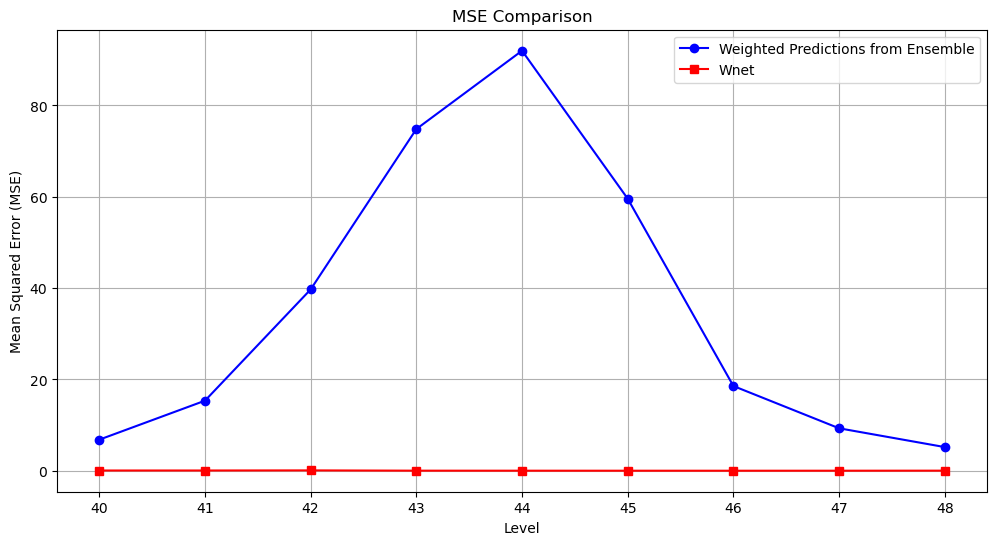

In [41]:
plt.figure(figsize=(12, 6))

# Plot for df_mse_ensemble
plt.plot(df_mse_ensemble['Level'], df_mse_ensemble['MSE Weighted Predictions'], 'o-', color='b', label='Weighted Predictions from Ensemble')

# Plot for df_mse
plt.plot(df_mse['Level'], df_mse['MSE Wnet'], 's-', color='r', label='Wnet')

# Adding titles and labels
plt.title('MSE Comparison')
plt.xlabel('Level')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)


In [ ]:
\